<a href="https://colab.research.google.com/github/joyceee916/ATMS-597-SP-2020-Project-4/blob/master/Project4_Joyce_v2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import seaborn as sns; sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
cd /content/drive/My Drive/ATMS 597/Project4

/content/drive/My Drive/ATMS 597/Project4


Importing KCMI Observational Data

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [134]:
KCMI_daily = pd.read_csv("KCMI_daily_format.csv", parse_dates=True, index_col='Date')
KCMI_daily.rename(columns={'TMAX(C)': 'TMAX_Obs', 'TMIN(C)': 'TMIN_Obs', 'WMAX(M/s)': 'WMAX_Obs', 'PREC(mm}': 'RTOT_Obs'}, inplace = True)
KCMI_daily.dropna(inplace=True)
KCMI_daily.index = KCMI_daily.index + pd.DateOffset(hours=12)  
KCMI_daily = KCMI_daily.rename_axis('Time')
KCMI_daily.head()

,TMAX_Obs,TMIN_Obs,WMAX_Obs,RTOT_Obs
Time,,,,
2010-01-01 12:00:00,-11.111111,-16.666667,6.70560,0.0
2010-01-02 12:00:00,-14.444444,-20.555556,6.70560,0.0
2010-01-03 12:00:00,-12.222222,-21.111111,4.91744,0.0
2010-01-04 12:00:00,-11.666667,-18.888889,8.94080,0.0
2010-01-05 12:00:00,-12.222222,-18.333333,7.15264,0.0


GFS Daily Model 

In [135]:
GFS_daily = pd.read_csv("GFS_daily_2010_2019_test.csv", parse_dates=True, index_col='Time')
GFS_daily.drop(columns="Unnamed: 0", inplace=True)
GFS_daily.rename(columns={'TMAX': 'TMAX_GFS', 'TMIN': 'TMIN_GFS', 'WMAX': 'WMAX_GFS', 'RTOT': 'RTOT_GFS'}, inplace = True)
GFS_daily.dropna(inplace=True)
GFS_daily.head()

,TMAX_GFS,TMIN_GFS,WMAX_GFS,RTOT_GFS
Time,,,,
2010-01-01 12:00:00,-11.26,-16.46,7.323933,0.05
2010-01-02 12:00:00,-10.16,-15.96,4.687217,0.00
2010-01-03 12:00:00,-9.96,-14.36,5.941380,0.06
2010-01-04 12:00:00,-8.46,-12.86,5.685068,0.17
2010-01-05 12:00:00,-7.16,-11.06,3.794733,0.77


GFS Surface Data

In [0]:
GFS_surface = pd.read_csv("GFS_Sfc_new.csv", parse_dates=True, index_col='Time')
GFS_surface.rename(columns={'DWPC': 'DWPC_Surf', 'HCLD': 'HCLD_Surf', 'LCLD': 'LCLD_Surf', 'MCLD': 'MCLD_Surf',
                            'PRCP': 'PRCP_Surf', 'PRES': 'PRES_Surf', 'TMPC': 'TMPC_Surf', 'UWND': 'UWND_Surf',
                            'VWND': 'VWND_Surf', 'WSPD': 'WSPD_Surf'}, inplace = True)
GFS_surface.dropna(inplace=True)
GFS_surface.head(10)
GFS_surface.replace({9999.0: np.nan}, inplace=True)
GFS_surface.replace({-9999.0: np.nan}, inplace=True)

In [137]:
# shift data back 6 hours and resample by day 
GFS_surface.index = GFS_surface.index + pd.DateOffset(hours = -6)
GFS_surface = GFS_surface.resample('24H').max()

# shift the data forward 12 hours for ease of merging with other datasets 
GFS_surface.index = GFS_surface.index + pd.DateOffset(hours = 12)
GFS_surface.head(10)

,DWPC_Surf,HCLD_Surf,LCLD_Surf,MCLD_Surf,PRCP_Surf,PRES_Surf,TMPC_Surf,UWND_Surf,VWND_Surf,WSPD_Surf
Time,,,,,,,,,,
2010-01-02 12:00:00,-13.74,0.0,100.0,1.0,0.04,1002.0,-11.26,4.9,-4.0,7.323933
2010-01-03 12:00:00,-14.21,42.0,7.0,1.0,0.00,1001.8,-10.16,3.6,-2.5,4.687217
2010-01-04 12:00:00,-12.63,95.0,99.0,91.0,0.03,999.8,-9.96,4.4,-3.5,5.941380
2010-01-05 12:00:00,-10.75,94.0,100.0,67.0,0.03,997.3,-8.46,4.6,-2.7,5.685068
2010-01-06 12:00:00,-9.45,90.0,100.0,100.0,0.05,996.0,-7.16,3.6,0.1,3.794733
2010-01-07 12:00:00,-6.13,100.0,100.0,100.0,2.06,992.5,-5.46,5.3,2.4,6.888396
2010-01-08 12:00:00,-4.15,34.0,100.0,6.0,0.63,1000.0,-3.46,5.3,-2.0,8.645230
2010-01-09 12:00:00,-10.81,0.0,100.0,0.0,0.02,1004.9,-8.56,2.9,-2.4,4.441846
2010-01-10 12:00:00,-9.09,80.0,3.0,62.0,0.00,1005.7,-7.26,4.3,5.7,6.824954


GFS Profile Data

In [228]:
GFS_profile = pd.read_csv('GFS_profile_new.csv', index_col='Time', parse_dates=True)
GFS_profile = GFS_profile.drop('PRES', axis=1)

def extract_var_GFS_profile(var, level, method='mean'):
    list = []
    levels = [925.0, 850.0, 700.0, 500.0, 250.0, 100.0]
    x = levels.index(level)
    h = GFS_profile[var].str.strip('[|]|,').values
    for i in range(0,len(GFS_profile)):
        e = h[i].split(',')[x]
        list.append(e)
    new_col_name = var + '_' + str(level) + '_' + method
    GFS_profile[new_col_name]=list

GFS_profile.head(10)

,DWPC,HGHT,TMPC,UWND,VWND
Time,,,,,
2010-01-02 09:00:00,"[-19.453124999999996, -24.9388679245283, -42.0...","[822.0543749999998, 1459.7785849056602, 2907.4...","[-17.247500000000002, -16.19490566037736, -20....","[13.681992680084207, 9.948942540840713, 19.953...","[-21.05132415236028, -17.798267800386434, -29...."
2010-01-02 12:00:00,"[-24.917708333333334, -29.536603773584904, -42...","[820.327638888889, 1459.582075471698, 2915.667...","[-15.991249999999997, -15.280283018867925, -19...","[12.509088069631126, 14.999567192631927, 23.33...","[-25.372665670766228, -22.851012927878898, -32..."
2010-01-02 15:00:00,"[-29.030482758620682, -37.651971830985914, -43...","[826.2597241379308, 1463.5210798122066, 2927.6...","[-18.595172413793104, -14.76, -16.487358490566...","[11.080763032604898, 13.737749044170894, 22.27...","[-20.65371472040801, -25.032875351390114, -38...."
2010-01-02 18:00:00,"[-24.84875862068967, -32.677452830188685, -41....","[823.4282758620693, 1458.4197169811318, 2927.1...","[-19.58413793103448, -15.190188679245283, -15....","[11.173738737104433, 11.725204010079779, 25.07...","[-14.419104627678692, -22.850212323925128, -37..."
2010-01-02 21:00:00,"[-23.723541666666648, -31.231603773584904, -41...","[814.5235416666663, 1451.7584905660376, 2924.7...","[-18.52666666666667, -14.439245283018868, -14....","[9.280847437628964, 13.398593774093092, 28.752...","[-16.548989694297227, -22.417731320168485, -37..."
2010-01-03 00:00:00,"[-27.292965517241385, -32.07079812206573, -41....","[818.8129655172417, 1456.3933333333334, 2930.5...","[-17.499310344827585, -14.52056338028169, -14....","[3.511034750622741, 11.005251667788372, 30.469...","[-18.2430697535647, -23.400538147416142, -38.7..."
2010-01-03 03:00:00,"[-27.28510344827586, -33.31539906103286, -43.7...","[820.7152413793101, 1458.8048356807508, 2934.9...","[-16.711724137931036, -14.65342723004695, -13....","[1.184391613594784, 6.8638483403032735, 24.840...","[-14.134740826662464, -19.89592389230682, -38...."
2010-01-03 06:00:00,"[-25.6275, -33.05830188679246, -45.49559748427...","[820.549166666667, 1458.3049056603775, 2932.43...","[-16.143333333333334, -15.216603773584906, -13...","[-1.9754764134434684, 3.0071145961088406, 20.2...","[-8.494140743342218, -13.48674534777446, -32.1..."
2010-01-03 09:00:00,"[-25.32289655172414, -36.40773584905661, -54.5...","[830.0362068965519, 1470.5566981132076, 2950.2...","[-15.045517241379311, -13.749622641509434, -13...","[-1.1401223495843993, 7.55789015786737, 25.258...","[-8.856988921573311, -19.678129663920014, -25...."


In [229]:
method = ['mean', 'min', 'max', 'sum']
GFS_profile_names = ['DWPC', 'HGHT', 'TMPC', 'UWND', 'VWND']
levels = [925.0, 850.0, 700.0, 500.0] 
for i in GFS_profile_names:
    for j in levels:     
        for m in method:   
            extract_var_GFS_profile(var=i, level=j, method=m)

GFS_profile = GFS_profile.drop(GFS_profile_names, axis=1)
GFS_profile.dropna(inplace=True)
GFS_profile = GFS_profile.astype(float)

GFS_profile.index = GFS_profile.index + pd.DateOffset(hours = -6)

GFS_profile.head(10)

,DWPC_925.0_mean,DWPC_925.0_min,DWPC_925.0_max,DWPC_925.0_sum,DWPC_850.0_mean,DWPC_850.0_min,DWPC_850.0_max,DWPC_850.0_sum,DWPC_700.0_mean,DWPC_700.0_min,DWPC_700.0_max,DWPC_700.0_sum,DWPC_500.0_mean,DWPC_500.0_min,DWPC_500.0_max,DWPC_500.0_sum,HGHT_925.0_mean,HGHT_925.0_min,HGHT_925.0_max,HGHT_925.0_sum,HGHT_850.0_mean,HGHT_850.0_min,HGHT_850.0_max,HGHT_850.0_sum,HGHT_700.0_mean,HGHT_700.0_min,HGHT_700.0_max,HGHT_700.0_sum,HGHT_500.0_mean,HGHT_500.0_min,HGHT_500.0_max,HGHT_500.0_sum,TMPC_925.0_mean,TMPC_925.0_min,TMPC_925.0_max,TMPC_925.0_sum,TMPC_850.0_mean,TMPC_850.0_min,TMPC_850.0_max,TMPC_850.0_sum,TMPC_700.0_mean,TMPC_700.0_min,TMPC_700.0_max,TMPC_700.0_sum,TMPC_500.0_mean,TMPC_500.0_min,TMPC_500.0_max,TMPC_500.0_sum,UWND_925.0_mean,UWND_925.0_min,UWND_925.0_max,UWND_925.0_sum,UWND_850.0_mean,UWND_850.0_min,UWND_850.0_max,UWND_850.0_sum,UWND_700.0_mean,UWND_700.0_min,UWND_700.0_max,UWND_700.0_sum,UWND_500.0_mean,UWND_500.0_min,UWND_500.0_max,UWND_500.0_sum,VWND_925.0_mean,VWND_925.0_min,VWND_925.0_max,VWND_925.0_sum,VWND_850.0_mean,VWND_850.0_min,VWND_850.0_max,VWND_850.0_sum,VWND_700.0_mean,VWND_700.0_min,VWND_700.0_max,VWND_700.0_sum,VWND_500.0_mean,VWND_500.0_min,VWND_500.0_max,VWND_500.0_sum
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-02 03:00:00,-19.453125,-19.453125,-19.453125,-19.453125,-24.938868,-24.938868,-24.938868,-24.938868,-42.044969,-42.044969,-42.044969,-42.044969,-58.101408,-58.101408,-58.101408,-58.101408,822.054375,822.054375,822.054375,822.054375,1459.778585,1459.778585,1459.778585,1459.778585,2907.494277,2907.494277,2907.494277,2907.494277,5354.199859,5354.199859,5354.199859,5354.199859,-17.247500,-17.247500,-17.247500,-17.247500,-16.194906,-16.194906,-16.194906,-16.194906,-20.492075,-20.492075,-20.492075,-20.492075,-28.695775,-28.695775,-28.695775,-28.695775,13.681993,13.681993,13.681993,13.681993,9.948943,9.948943,9.948943,9.948943,19.953202,19.953202,19.953202,19.953202,54.090614,54.090614,54.090614,54.090614,-21.051324,-21.051324,-21.051324,-21.051324,-17.798268,-17.798268,-17.798268,-17.798268,-29.894744,-29.894744,-29.894744,-29.894744,-60.208588,-60.208588,-60.208588,-60.208588
2010-01-02 06:00:00,-24.917708,-24.917708,-24.917708,-24.917708,-29.536604,-29.536604,-29.536604,-29.536604,-42.674858,-42.674858,-42.674858,-42.674858,-55.715014,-55.715014,-55.715014,-55.715014,820.327639,820.327639,820.327639,820.327639,1459.582075,1459.582075,1459.582075,1459.582075,2915.667950,2915.667950,2915.667950,2915.667950,5377.602197,5377.602197,5377.602197,5377.602197,-15.991250,-15.991250,-15.991250,-15.991250,-15.280283,-15.280283,-15.280283,-15.280283,-19.139495,-19.139495,-19.139495,-19.139495,-28.294930,-28.294930,-28.294930,-28.294930,12.509088,12.509088,12.509088,12.509088,14.999567,14.999567,14.999567,14.999567,23.339134,23.339134,23.339134,23.339134,49.456141,49.456141,49.456141,49.456141,-25.372666,-25.372666,-25.372666,-25.372666,-22.851013,-22.851013,-22.851013,-22.851013,-32.155494,-32.155494,-32.155494,-32.155494,-64.273236,-64.273236,-64.273236,-64.273236
2010-01-02 09:00:00,-29.030483,-29.030483,-29.030483,-29.030483,-37.651972,-37.651972,-37.651972,-37.651972,-43.764434,-43.764434,-43.764434,-43.764434,-61.130393,-61.130393,-61.130393,-61.130393,826.259724,826.259724,826.259724,826.259724,1463.521080,1463.521080,1463.521080,1463.521080,2927.647170,2927.647170,2927.647170,2927.647170,5403.780674,5403.780674,5403.780674,5403.780674,-18.595172,-18.595172,-18.595172,-18.595172,-14.760000,-14.760000,-14.760000,-14.760000,-16.487358,-16.487358,-16.487358,-16.487358,-26.731348,-26.731348,-26.731348,-26.731348,11.080763,11.080763,11.080763,11.080763,13.737749,13.737749,13.737749,13.737749,22.274664,22.274664,22.274664,22.274664,47.883198,47.883198,47.883198,47.883198,-20.653715,-20.653715,-20.653715,-20.653715,-25.032875,-25.032875,-25.032875,-25.032875,-38.072166,-38.072166,-38.072166,-38.072166,-59.949929,-59.949929,-59.949929,-59.949929
2010-01-02

In [0]:
GFS_profile.index = GFS_profile.index + pd.DateOffset(hours = -6)
GFS_profile = GFS_profile.resample('24H').mean()
GFS_profile.index = GFS_profile.index + pd.DateOffset(hours = 12)
GFS_profile.head()

In [138]:
## RUN FOR MEAN

GFS_profile = GFS_profile.drop(GFS_profile_names, axis=1)
GFS_profile = GFS_profile.drop('PRES', axis=1)
GFS_profile.dropna(inplace=True)
GFS_profile = GFS_profile.astype(float)

GFS_profile.index = GFS_profile.index + pd.DateOffset(hours = -6)
GFS_profile = GFS_profile.resample('24H').mean()
GFS_profile.index = GFS_profile.index + pd.DateOffset(hours = 12)
GFS_profile.head()

,DWPC_925.0_mean,DWPC_850.0_mean,DWPC_700.0_mean,DWPC_500.0_mean,HGHT_925.0_mean,HGHT_850.0_mean,HGHT_700.0_mean,HGHT_500.0_mean,TMPC_925.0_mean,TMPC_850.0_mean,TMPC_700.0_mean,TMPC_500.0_mean,UWND_925.0_mean,UWND_850.0_mean,UWND_700.0_mean,UWND_500.0_mean,VWND_925.0_mean,VWND_850.0_mean,VWND_700.0_mean,VWND_500.0_mean
Time,,,,,,,,,,,,,,,,,,,,
2010-01-02 12:00:00,-25.221669,-31.631814,-42.343174,-49.713078,820.874537,1458.322588,2924.016943,5404.973406,-17.736537,-15.005516,-16.276659,-26.871957,8.917408,11.668451,24.957946,49.957403,-18.631944,-22.035223,-36.006022,-53.129106
2010-01-03 12:00:00,-24.612461,-33.524255,-45.006084,-38.011418,825.026208,1466.561942,2943.248216,5429.166073,-14.528163,-13.728910,-14.633226,-28.177380,0.966968,2.928479,13.929298,34.531889,-8.503009,-12.642454,-22.324673,-29.460048
2010-01-04 12:00:00,-19.773137,-24.218344,-25.096941,-42.369095,808.518112,1455.589841,2932.208504,5390.650047,-13.448896,-11.433527,-16.459748,-31.019731,7.613226,6.086299,6.925063,7.042113,-18.257766,-18.436342,-22.440240,-22.675592
2010-01-05 12:00:00,-15.254223,-17.749616,-24.500529,-39.556158,796.682736,1446.840629,2934.372470,5413.979393,-12.478941,-9.982257,-14.372026,-29.423196,7.118404,5.853575,9.920349,12.764679,-15.989024,-18.744676,-22.421572,-19.083133
2010-01-06 12:00:00,-16.456283,-26.308794,-26.778580,-37.508100,787.429840,1442.774700,2938.356597,5443.111685,-9.918127,-8.066827,-13.002703,-26.093287,7.004508,9.396605,16.897229,30.434990,-6.298893,-7.324372,-8.470288,-15.845163


In [170]:
## RUN FOR MIN
GFS_profile = pd.read_csv('GFS_profile_new.csv', index_col='Time', parse_dates=True)

def extract_var_GFS_profile(var, level):
    list = []
    levels = [925.0, 850.0, 700.0, 500.0, 250.0, 100.0]
    x = levels.index(level)
    h = GFS_profile[var].str.strip('[|]|,').values
    for i in range(0,len(GFS_profile)):
        e = h[i].split(',')[x]
        list.append(e)
    new_col_name = var + '_' + str(level) + '_min'
    GFS_profile[new_col_name]=list

GFS_profile_names = ['DWPC', 'HGHT', 'TMPC', 'UWND', 'VWND']
levels = [925.0, 850.0, 700.0, 500.0]
for i in GFS_profile_names:
    for j in levels:        
        extract_var_GFS_profile(i,j)
GFS_profile = GFS_profile.drop(GFS_profile_names, axis=1)
GFS_profile = GFS_profile.drop('PRES', axis=1)
GFS_profile.dropna(inplace=True)
GFS_profile = GFS_profile.astype(float)

GFS_profile.index = GFS_profile.index + pd.DateOffset(hours = -6)
GFS_profile = GFS_profile.resample('24H').min()
GFS_profile.index = GFS_profile.index + pd.DateOffset(hours = 12)
GFS_profile.head()

,DWPC_925.0_min,DWPC_850.0_min,DWPC_700.0_min,DWPC_500.0_min,HGHT_925.0_min,HGHT_850.0_min,HGHT_700.0_min,HGHT_500.0_min,TMPC_925.0_min,TMPC_850.0_min,TMPC_700.0_min,TMPC_500.0_min,UWND_925.0_min,UWND_850.0_min,UWND_700.0_min,UWND_500.0_min,VWND_925.0_min,VWND_850.0_min,VWND_700.0_min,VWND_500.0_min
Time,,,,,,,,,,,,,,,,,,,,
2010-01-02 12:00:00,-29.030483,-37.651972,-43.782516,-61.130393,814.523542,1451.758491,2907.494277,5354.199859,-19.584138,-16.194906,-20.492075,-28.695775,1.184392,6.863848,19.953202,46.670103,-25.372666,-25.032875,-38.751478,-64.273236
2010-01-03 12:00:00,-28.167222,-37.752113,-54.588994,-44.951972,820.201944,1458.304906,2932.431478,5409.086930,-16.143333,-15.216604,-16.036025,-30.133803,-1.975476,-1.047952,4.517203,28.443411,-12.201104,-19.678130,-32.156633,-38.970599
2010-01-04 12:00:00,-25.736667,-28.880000,-33.074543,-55.621521,798.919845,1445.780849,2922.815570,5385.365609,-14.453023,-11.718768,-17.033817,-32.215775,3.499557,3.498790,3.863955,-7.262986,-20.981695,-21.042502,-24.897778,-31.636565
2010-01-05 12:00:00,-16.711462,-27.261374,-32.457111,-49.697932,792.987442,1441.856604,2924.047429,5399.847797,-13.232093,-11.312607,-15.205714,-29.945552,4.083795,3.717828,5.985816,3.866994,-18.245399,-20.323602,-26.081872,-28.190929
2010-01-06 12:00:00,-18.422791,-33.553223,-35.033016,-48.678754,775.072481,1428.689762,2924.711338,5416.427762,-10.843721,-9.276190,-14.790380,-28.913541,3.979381,3.751039,13.818173,20.133067,-13.453594,-16.445561,-14.992880,-30.111094


In [0]:
## RUN FOR MAX
GFS_profile = pd.read_csv('GFS_profile_new.csv', index_col='Time', parse_dates=True)

def extract_var_GFS_profile(var, level):
    list = []
    levels = [925.0, 850.0, 700.0, 500.0, 250.0, 100.0]
    x = levels.index(level)
    h = GFS_profile[var].str.strip('[|]|,').values
    for i in range(0,len(GFS_profile)):
        e = h[i].split(',')[x]
        list.append(e)
    new_col_name = var + '_' + str(level) + '_max'
    GFS_profile[new_col_name]=list

GFS_profile_names = ['DWPC', 'HGHT', 'TMPC', 'UWND', 'VWND']
levels = [925.0, 850.0, 700.0, 500.0]
for i in GFS_profile_names:
    for j in levels:        
        extract_var_GFS_profile(i,j)
GFS_profile = GFS_profile.drop(GFS_profile_names, axis=1)
GFS_profile = GFS_profile.drop('PRES', axis=1)
GFS_profile.dropna(inplace=True)
GFS_profile = GFS_profile.astype(float)

GFS_profile.index = GFS_profile.index + pd.DateOffset(hours = -6)
GFS_profile = GFS_profile.resample('24H').max()
GFS_profile.index = GFS_profile.index + pd.DateOffset(hours = 12)
GFS_profile.head()

In [0]:
## RUN FOR SUM
GFS_profile = pd.read_csv('GFS_profile_new.csv', index_col='Time', parse_dates=True)

def extract_var_GFS_profile(var, level):
    list = []
    levels = [925.0, 850.0, 700.0, 500.0, 250.0, 100.0]
    x = levels.index(level)
    h = GFS_profile[var].str.strip('[|]|,').values
    for i in range(0,len(GFS_profile)):
        e = h[i].split(',')[x]
        list.append(e)
    new_col_name = var + '_' + str(level) + '_sum'
    GFS_profile[new_col_name]=list

GFS_profile_names = ['DWPC', 'HGHT', 'TMPC', 'UWND', 'VWND']
levels = [925.0, 850.0, 700.0, 500.0]
for i in GFS_profile_names:
    for j in levels:        
        extract_var_GFS_profile(i,j)
GFS_profile = GFS_profile.drop(GFS_profile_names, axis=1)
GFS_profile = GFS_profile.drop('PRES', axis=1)
GFS_profile.dropna(inplace=True)
GFS_profile = GFS_profile.astype(float)

GFS_profile.index = GFS_profile.index + pd.DateOffset(hours = -6)
GFS_profile = GFS_profile.resample('24H').sum()
GFS_profile.index = GFS_profile.index + pd.DateOffset(hours = 12)
GFS_profile.head()

Combine Datasets

In [171]:
# Combine GFS daily and KCMI daily
df1 = pd.merge(GFS_daily.reset_index(), KCMI_daily.reset_index(), on='Time', how='inner')
df1.Time = pd.to_datetime(df1.Time)
df1['Year'] = df1.Time.dt.year
df1['D_TMAX'] = df1['TMAX_GFS']-df1['TMAX_Obs']
df1['D_TMIN'] = df1['TMIN_GFS']-df1['TMIN_Obs']
df1['D_WMAX'] = df1['WMAX_GFS']-df1['WMAX_Obs']
df1['D_RTOT'] = df1['RTOT_GFS']-df1['RTOT_Obs']
df1

,Time,TMAX_GFS,TMIN_GFS,WMAX_GFS,RTOT_GFS,TMAX_Obs,TMIN_Obs,WMAX_Obs,RTOT_Obs,Year,D_TMAX,D_TMIN,D_WMAX,D_RTOT
0,2010-01-01 12:00:00,-11.26,-16.46,7.323933,0.05,-11.111111,-16.666667,6.70560,0.0,2010,-0.148889,0.206667,0.618333,0.05
1,2010-01-02 12:00:00,-10.16,-15.96,4.687217,0.00,-14.444444,-20.555556,6.70560,0.0,2010,4.284444,4.595556,-2.018383,0.00
2,2010-01-03 12:00:00,-9.96,-14.36,5.941380,0.06,-12.222222,-21.111111,4.91744,0.0,2010,2.262222,6.751111,1.023940,0.06
3,2010-01-04 12:00:00,-8.46,-12.86,5.685068,0.17,-11.666667,-18.888889,8.94080,0.0,2010,3.206667,6.028889,-3.255732,0.17
4,2010-01-05 12:00:00,-7.16,-11.06,3.794733,0.77,-12.222222,-18.333333,7.15264,0.0,2010,5.062222,7.273333,-3.357907,0.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3571,2019-12-27 12:00:00,13.94,3.54,8.819297,2.73,6.111111,0.000000,6.70560,0.0,2019,7.828889,3.540000,2.113697,2.73
3572,2019-12-28 12:00:00,15.94,9.34,9.701546,11.58,13.333333,0.000000,10.28192,2.8,2019,2.606667,9.340000,-0.580374,8.78
3573,2019-12-29 12:00:00,7.24,-1.66,11.111256,2.57,15.000000,5.000000,10.28192,4.3,2019,-7.760000,-6.660000,0.829336,-1.73
3574,2019-12-30 12:00:00,-0.36,-2.26,8.769265,0.04,3.333333,-0.555556,11.62304,0.6,2019,-3.693333,-1.704444,-2.853775,-0.56


In [172]:
# Combine GFS Profile and GFS Surface 
df2 = pd.merge(GFS_surface.reset_index(), GFS_profile.reset_index(), on='Time', how='inner')
df2.Time = pd.to_datetime(df2.Time)
df2.head()

,Time,DWPC_Surf,HCLD_Surf,LCLD_Surf,MCLD_Surf,PRCP_Surf,PRES_Surf,TMPC_Surf,UWND_Surf,VWND_Surf,WSPD_Surf,DWPC_925.0_min,DWPC_850.0_min,DWPC_700.0_min,DWPC_500.0_min,HGHT_925.0_min,HGHT_850.0_min,HGHT_700.0_min,HGHT_500.0_min,TMPC_925.0_min,TMPC_850.0_min,TMPC_700.0_min,TMPC_500.0_min,UWND_925.0_min,UWND_850.0_min,UWND_700.0_min,UWND_500.0_min,VWND_925.0_min,VWND_850.0_min,VWND_700.0_min,VWND_500.0_min
0,2010-01-02 12:00:00,-13.74,0.0,100.0,1.0,0.04,1002.0,-11.26,4.9,-4.0,7.323933,-29.030483,-37.651972,-43.782516,-61.130393,814.523542,1451.758491,2907.494277,5354.199859,-19.584138,-16.194906,-20.492075,-28.695775,1.184392,6.863848,19.953202,46.670103,-25.372666,-25.032875,-38.751478,-64.273236
1,2010-01-03 12:00:00,-14.21,42.0,7.0,1.0,0.00,1001.8,-10.16,3.6,-2.5,4.687217,-28.167222,-37.752113,-54.588994,-44.951972,820.201944,1458.304906,2932.431478,5409.086930,-16.143333,-15.216604,-16.036025,-30.133803,-1.975476,-1.047952,4.517203,28.443411,-12.201104,-19.678130,-32.156633,-38.970599
2,2010-01-04 12:00:00,-12.63,95.0,99.0,91.0,0.03,999.8,-9.96,4.4,-3.5,5.941380,-25.736667,-28.880000,-33.074543,-55.621521,798.919845,1445.780849,2922.815570,5385.365609,-14.453023,-11.718768,-17.033817,-32.215775,3.499557,3.498790,3.863955,-7.262986,-20.981695,-21.042502,-24.897778,-31.636565
3,2010-01-05 12:00:00,-10.75,94.0,100.0,67.0,0.03,997.3,-8.46,4.6,-2.7,5.685068,-16.711462,-27.261374,-32.457111,-49.697932,792.987442,1441.856604,2924.047429,5399.847797,-13.232093,-11.312607,-15.205714,-29.945552,4.083795,3.717828,5.985816,3.866994,-18.245399,-20.323602,-26.081872,-28.190929
4,2010-01-06 12:00:00,-9.45,90.0,100.0,100.0,0.05,996.0,-7.16,3.6,0.1,3.794733,-18.422791,-33.553223,-35.033016,-48.678754,775.072481,1428.689762,2924.711338,5416.427762,-10.843721,-9.276190,-14.790380,-28.913541,3.979381,3.751039,13.818173,20.133067,-13.453594,-16.445561,-14.992880,-30.111094


In [173]:
# Combine two intermediate datasets into one feature matrix
features_df = pd.merge(df1.reset_index(), df2.reset_index(), on='Time', how='inner')
features_df.Time = pd.to_datetime(features_df.Time)
features_df.dropna(inplace=True)
features_df.head()

,index_x,Time,TMAX_GFS,TMIN_GFS,WMAX_GFS,RTOT_GFS,TMAX_Obs,TMIN_Obs,WMAX_Obs,RTOT_Obs,Year,D_TMAX,D_TMIN,D_WMAX,D_RTOT,index_y,DWPC_Surf,HCLD_Surf,LCLD_Surf,MCLD_Surf,PRCP_Surf,PRES_Surf,TMPC_Surf,UWND_Surf,VWND_Surf,WSPD_Surf,DWPC_925.0_min,DWPC_850.0_min,DWPC_700.0_min,DWPC_500.0_min,HGHT_925.0_min,HGHT_850.0_min,HGHT_700.0_min,HGHT_500.0_min,TMPC_925.0_min,TMPC_850.0_min,TMPC_700.0_min,TMPC_500.0_min,UWND_925.0_min,UWND_850.0_min,UWND_700.0_min,UWND_500.0_min,VWND_925.0_min,VWND_850.0_min,VWND_700.0_min,VWND_500.0_min
0,1,2010-01-02 12:00:00,-10.16,-15.96,4.687217,0.00,-14.444444,-20.555556,6.70560,0.0,2010,4.284444,4.595556,-2.018383,0.00,0,-13.74,0.0,100.0,1.0,0.04,1002.0,-11.26,4.9,-4.0,7.323933,-29.030483,-37.651972,-43.782516,-61.130393,814.523542,1451.758491,2907.494277,5354.199859,-19.584138,-16.194906,-20.492075,-28.695775,1.184392,6.863848,19.953202,46.670103,-25.372666,-25.032875,-38.751478,-64.273236
1,2,2010-01-03 12:00:00,-9.96,-14.36,5.941380,0.06,-12.222222,-21.111111,4.91744,0.0,2010,2.262222,6.751111,1.023940,0.06,1,-14.21,42.0,7.0,1.0,0.00,1001.8,-10.16,3.6,-2.5,4.687217,-28.167222,-37.752113,-54.588994,-44.951972,820.201944,1458.304906,2932.431478,5409.086930,-16.143333,-15.216604,-16.036025,-30.133803,-1.975476,-1.047952,4.517203,28.443411,-12.201104,-19.678130,-32.156633,-38.970599
2,3,2010-01-04 12:00:00,-8.46,-12.86,5.685068,0.17,-11.666667,-18.888889,8.94080,0.0,2010,3.206667,6.028889,-3.255732,0.17,2,-12.63,95.0,99.0,91.0,0.03,999.8,-9.96,4.4,-3.5,5.941380,-25.736667,-28.880000,-33.074543,-55.621521,798.919845,1445.780849,2922.815570,5385.365609,-14.453023,-11.718768,-17.033817,-32.215775,3.499557,3.498790,3.863955,-7.262986,-20.981695,-21.042502,-24.897778,-31.636565
3,4,2010-01-05 12:00:00,-7.16,-11.06,3.794733,0.77,-12.222222,-18.333333,7.15264,0.0,2010,5.062222,7.273333,-3.357907,0.77,3,-10.75,94.0,100.0,67.0,0.03,997.3,-8.46,4.6,-2.7,5.685068,-16.711462,-27.261374,-32.457111,-49.697932,792.987442,1441.856604,2924.047429,5399.847797,-13.232093,-11.312607,-15.205714,-29.945552,4.083795,3.717828,5.985816,3.866994,-18.245399,-20.323602,-26.081872,-28.190929
4,5,2010-01-06 12:00:00,-5.46,-7.46,9.548298,7.10,-7.777778,-19.444444,3.57632,1.5,2010,2.317778,11.984444,5.971978,5.60,4,-9.45,90.0,100.0,100.0,0.05,996.0,-7.16,3.6,0.1,3.794733,-18.422791,-33.553223,-35.033016,-48.678754,775.072481,1428.689762,2924.711338,5416.427762,-10.843721,-9.276190,-14.790380,-28.913541,3.979381,3.751039,13.818173,20.133067,-13.453594,-16.445561,-14.992880,-30.111094


In [0]:
# Split into training and test sets 
# Can change features 
x_train_all = features_df[features_df.Time.dt.year<2019]
x_test_all = features_df[features_df.Time.dt.year==2019]

y_train_all = features_df[features_df.Time.dt.year<2019]
y_test_all = features_df[features_df.Time.dt.year==2019]

Linear Regression

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.model_selection import train_test_split
from math import sqrt

**Linear Regression**

Max Temperature

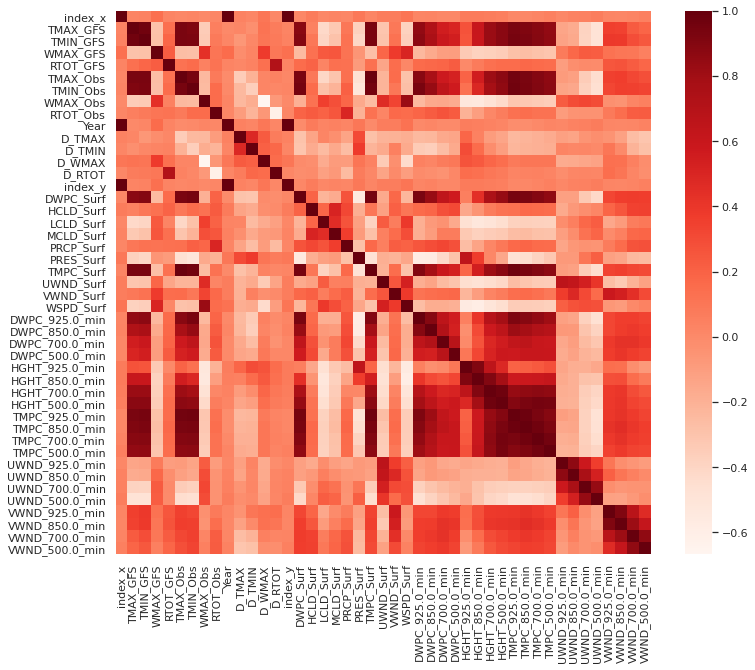

In [176]:
plt.figure(figsize=(12,10))
cor = features_df.corr()
sns.heatmap(cor, cmap=plt.cm.Reds)
plt.show()

In [0]:
def lin_model_func(features, target):
    lin_model = LinearRegression()
    x_train = x_train_all[features]
    y_train = y_train_all[target]

    x_test = x_test_all[features]
    y_test = y_test_all[target]

    lin_model.fit(x_train, y_train)

    # Print parameters and plot - GFS Data
    print('Coefficients: \n', lin_model.coef_)
    print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error(y_test, lin_model.predict(x_test)))
    print("The Median Absolute Error: %.2f degrees celsius" % median_absolute_error(y_test, lin_model.predict(x_test)))
    print("The Root Mean Square Error: %.2f degrees celsius " %  sqrt(mean_squared_error(y_test, lin_model.predict(x_test))))

    print('Coefficient of determination: %.2f' % r2_score(y_test, lin_model.predict(x_test)))

    return x_test, y_test, lin_model


Max Temperature

In [180]:
# Correlation with output variable 
cor_target = abs(cor['TMAX_Obs'])

relevant_features = cor_target[cor_target>0.70]
features = relevant_features.keys().drop(['TMAX_Obs', 'TMIN_Obs'])
print(features)
target = ['TMAX_Obs']
x_test, y_test, lin_model = lin_model_func(features, target)

Index(['TMAX_GFS', 'TMIN_GFS', 'DWPC_Surf', 'TMPC_Surf', 'DWPC_925.0_min',
       'DWPC_850.0_min', 'HGHT_700.0_min', 'HGHT_500.0_min', 'TMPC_925.0_min',
       'TMPC_850.0_min', 'TMPC_700.0_min', 'TMPC_500.0_min'],
      dtype='object')
Coefficients: 
 [[ 5.39892094e-02 -6.43617189e-04  4.08786176e-03  8.79811483e-01
  -2.23922740e-02 -3.01068848e-02  6.02880991e-03 -6.52401205e-03
   2.01144836e-01 -6.91071981e-02  1.02913214e-01 -8.32285721e-03]]
The Mean Absolute Error: 1.46 degrees celsius
The Median Absolute Error: 1.15 degrees celsius
The Root Mean Square Error: 1.91 degrees celsius 
Coefficient of determination: 0.97


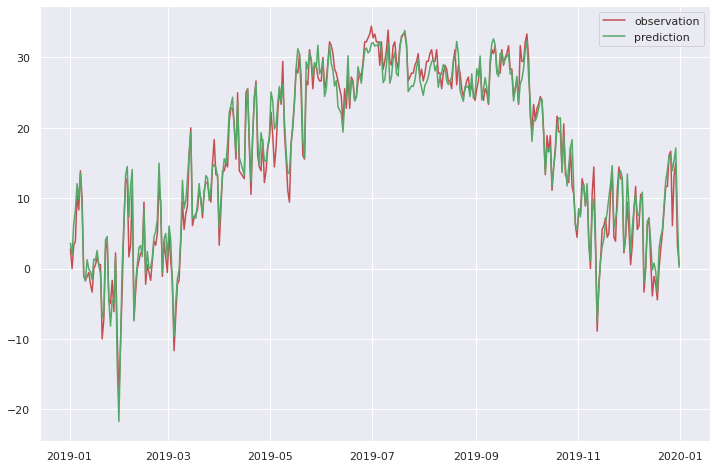

In [148]:
# Plot predicted values against observed values 
time = features_df[features_df['Year']==2019]['Time'].values
plt.figure(figsize=(12,8))
plt.plot(time, y_test, c='r', label='observation')
plt.plot(time, lin_model.predict(x_test), c='g', label='prediction')
plt.legend()
plt.savefig('linearregression.jpg')

Minimum Temperature

In [181]:
cor_target = abs(cor['TMIN_Obs'])

relevant_features = cor_target[cor_target>0.80]
features = relevant_features.keys().drop(['TMAX_Obs', 'TMIN_Obs'])
print(features)
target = ['TMIN_Obs']
x_test, y_test, lin_model = lin_model_func(features, target)

Index(['TMAX_GFS', 'TMIN_GFS', 'DWPC_Surf', 'TMPC_Surf', 'DWPC_925.0_min',
       'DWPC_850.0_min', 'HGHT_500.0_min', 'TMPC_925.0_min', 'TMPC_850.0_min',
       'TMPC_700.0_min', 'TMPC_500.0_min'],
      dtype='object')
Coefficients: 
 [[-0.02898347  0.1647034   0.1701411   0.14553103  0.20493128  0.0197315
  -0.0026038   0.30558339 -0.06942997 -0.01607121  0.1420253 ]]
The Mean Absolute Error: 1.91 degrees celsius
The Median Absolute Error: 1.67 degrees celsius
The Root Mean Square Error: 2.47 degrees celsius 
Coefficient of determination: 0.95


Maximum Wind Speed

In [182]:
cor_target = abs(cor['WMAX_Obs'])

relevant_features = cor_target[cor_target>0.30]
features = relevant_features.keys().drop(['WMAX_Obs', 'D_WMAX'])
print(features)
target = ['WMAX_Obs']
x_test, y_test, lin_model = lin_model_func(features, target)

Index(['TMAX_GFS', 'TMIN_GFS', 'WMAX_GFS', 'LCLD_Surf', 'UWND_Surf',
       'VWND_Surf', 'WSPD_Surf', 'HGHT_925.0_min', 'HGHT_850.0_min',
       'HGHT_700.0_min', 'HGHT_500.0_min', 'TMPC_925.0_min', 'TMPC_850.0_min',
       'TMPC_700.0_min', 'TMPC_500.0_min', 'UWND_850.0_min', 'UWND_700.0_min',
       'UWND_500.0_min'],
      dtype='object')
Coefficients: 
 [[ 3.92275585e-03 -2.07872839e-02 -3.29629623e-03  3.96436797e-04
  -8.38874484e-02 -3.11641244e-02  9.47611569e-01 -3.10607663e-02
   2.13750965e-02  7.17689455e-03 -1.58065382e-03  1.57968621e-02
  -5.55908661e-02 -8.80687930e-03 -4.01947046e-02  2.31218482e-02
   8.22317720e-03  2.62337640e-03]]
The Mean Absolute Error: 1.21 degrees celsius
The Median Absolute Error: 0.99 degrees celsius
The Root Mean Square Error: 1.59 degrees celsius 
Coefficient of determination: 0.72


Precipitation Accumulation

In [183]:
cor_target = abs(cor['RTOT_Obs'])

relevant_features = cor_target[cor_target>0.25]
features = relevant_features.keys().drop(['RTOT_Obs', 'D_RTOT'])
print(features)
target = ['RTOT_Obs']
x_test, y_test, lin_model = lin_model_func(features, target)

Index(['MCLD_Surf', 'PRCP_Surf', 'DWPC_700.0_min'], dtype='object')
Coefficients: 
 [[0.01455023 0.88763227 0.0597686 ]]
The Mean Absolute Error: 2.33 degrees celsius
The Median Absolute Error: 1.25 degrees celsius
The Root Mean Square Error: 4.01 degrees celsius 
Coefficient of determination: 0.36


**Random Forest**

In [0]:
# Create random forest regression model 
# some code adapted from (https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
from sklearn.ensemble import RandomForestRegressor 

In [0]:
# n_estimators and max_features can be lists 
def rf_model_func(features, target, n_estimators = 1000, max_features = 5):
    x_train = x_train_all[features]
    y_train = y_train_all[target]

    x_test = x_test_all[features]
    y_test = y_test_all[target]

    for n in n_estimators: 
        for m in max_features: 
            # Train the model 
            rf_model = RandomForestRegressor(n_estimators=n, max_features=m)
            rf_model.fit(x_train, y_train)

            # Print parameters and plot
            print("# of trees =", n)
            print("Max features = ", m)
            print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error(y_test, rf_model.predict(x_test)))
            print("The Median Absolute Error: %.2f degrees celsius" % median_absolute_error(y_test, rf_model.predict(x_test)))
            print("The Root Mean Square Error: %.2f degrees celsius " %  sqrt(mean_squared_error(y_test, rf_model.predict(x_test))))
            print('Coefficient of determination: %.2f' % r2_score(y_test, rf_model.predict(x_test)))

    print(sorted(zip(map(lambda x: round(x, 4), rf_model.feature_importances_), features), reverse=True))
    return x_test, y_test, rf_model

Maximum Temperature

In [187]:
cor_target = abs(cor['TMAX_Obs'])

relevant_features = cor_target[cor_target>0.70]
features = relevant_features.keys().drop(['TMAX_Obs', 'TMIN_Obs'])
print(features)

target = ['TMAX_Obs']

x_test, y_test, rf_model = rf_model_func(features, target, n_estimators = [100], max_features = [5]) 

Index(['TMAX_GFS', 'TMIN_GFS', 'DWPC_Surf', 'TMPC_Surf', 'DWPC_925.0_min',
       'DWPC_850.0_min', 'HGHT_700.0_min', 'HGHT_500.0_min', 'TMPC_925.0_min',
       'TMPC_850.0_min', 'TMPC_700.0_min', 'TMPC_500.0_min'],
      dtype='object')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


# of trees = 100
Max features =  5
The Mean Absolute Error: 1.51 degrees celsius
The Median Absolute Error: 1.18 degrees celsius
The Root Mean Square Error: 1.97 degrees celsius 
Coefficient of determination: 0.97
[(0.4352, 'TMPC_Surf'), (0.2734, 'TMPC_925.0_min'), (0.1146, 'TMIN_GFS'), (0.064, 'TMAX_GFS'), (0.0636, 'TMPC_850.0_min'), (0.0313, 'DWPC_Surf'), (0.0035, 'HGHT_500.0_min'), (0.0032, 'TMPC_700.0_min'), (0.0032, 'DWPC_925.0_min'), (0.0029, 'DWPC_850.0_min'), (0.0026, 'HGHT_700.0_min'), (0.0025, 'TMPC_500.0_min')]


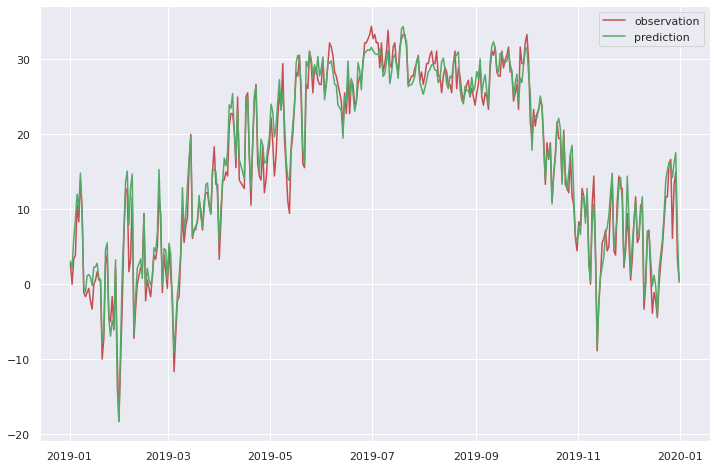

In [68]:
# Plot predicted values against observed values 
time = features_df[features_df['Year']==2019]['Time'].values
plt.figure(figsize=(12,8))
plt.plot(time, y_test, c='r', label='observation')
plt.plot(time, rf_model.predict(x_test), c='g', label='prediction')
plt.legend()
plt.savefig('randomforest.jpg')
plt.show()

Minimum Temperature

In [188]:
cor_target = abs(cor['TMIN_Obs'])

relevant_features = cor_target[cor_target>0.80]
features = relevant_features.keys().drop(['TMAX_Obs', 'TMIN_Obs'])
print(features)

target = ['TMIN_Obs']

x_test, y_test, rf_model = rf_model_func(features, target, n_estimators = [100], max_features = [5])


Index(['TMAX_GFS', 'TMIN_GFS', 'DWPC_Surf', 'TMPC_Surf', 'DWPC_925.0_min',
       'DWPC_850.0_min', 'HGHT_500.0_min', 'TMPC_925.0_min', 'TMPC_850.0_min',
       'TMPC_700.0_min', 'TMPC_500.0_min'],
      dtype='object')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


# of trees = 100
Max features =  5
The Mean Absolute Error: 1.73 degrees celsius
The Median Absolute Error: 1.52 degrees celsius
The Root Mean Square Error: 2.27 degrees celsius 
Coefficient of determination: 0.96
[(0.4031, 'TMPC_925.0_min'), (0.2585, 'TMPC_Surf'), (0.1058, 'TMPC_850.0_min'), (0.0984, 'DWPC_Surf'), (0.094, 'DWPC_925.0_min'), (0.0168, 'TMIN_GFS'), (0.0064, 'DWPC_850.0_min'), (0.006, 'TMAX_GFS'), (0.0044, 'TMPC_500.0_min'), (0.0034, 'HGHT_500.0_min'), (0.0031, 'TMPC_700.0_min')]


Wind Speed

In [189]:
cor_target = abs(cor['WMAX_Obs'])

relevant_features = cor_target[cor_target>0.30]
features = relevant_features.keys().drop(['WMAX_Obs', 'D_WMAX'])
print(features)

target = ['WMAX_Obs']

x_test, y_test, rf_model = rf_model_func(features, target, n_estimators = [100], max_features = [5])

Index(['TMAX_GFS', 'TMIN_GFS', 'WMAX_GFS', 'LCLD_Surf', 'UWND_Surf',
       'VWND_Surf', 'WSPD_Surf', 'HGHT_925.0_min', 'HGHT_850.0_min',
       'HGHT_700.0_min', 'HGHT_500.0_min', 'TMPC_925.0_min', 'TMPC_850.0_min',
       'TMPC_700.0_min', 'TMPC_500.0_min', 'UWND_850.0_min', 'UWND_700.0_min',
       'UWND_500.0_min'],
      dtype='object')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


# of trees = 100
Max features =  5
The Mean Absolute Error: 1.26 degrees celsius
The Median Absolute Error: 1.08 degrees celsius
The Root Mean Square Error: 1.59 degrees celsius 
Coefficient of determination: 0.72
[(0.3564, 'WSPD_Surf'), (0.1119, 'VWND_Surf'), (0.1075, 'UWND_Surf'), (0.0636, 'HGHT_925.0_min'), (0.0538, 'HGHT_850.0_min'), (0.0511, 'UWND_850.0_min'), (0.0301, 'WMAX_GFS'), (0.028, 'HGHT_500.0_min'), (0.0277, 'TMPC_500.0_min'), (0.025, 'TMAX_GFS'), (0.0238, 'HGHT_700.0_min'), (0.0228, 'UWND_700.0_min'), (0.0179, 'TMPC_925.0_min'), (0.0178, 'UWND_500.0_min'), (0.0178, 'TMPC_850.0_min'), (0.0177, 'TMIN_GFS'), (0.0154, 'TMPC_700.0_min'), (0.0118, 'LCLD_Surf')]


Precipitation

In [201]:
cor_target = abs(cor['RTOT_Obs'])

relevant_features = cor_target[cor_target>0.20]
print(relevant_features)
features = relevant_features.keys().drop(['RTOT_Obs', 'D_RTOT', 'D_TMIN'])
print(features)

target = ['RTOT_Obs']

x_test, y_test, rf_model = rf_model_func(features, target, n_estimators = [100], max_features = [5])

RTOT_Obs          1.000000
D_TMIN            0.212455
D_RTOT            0.610521
HCLD_Surf         0.232132
LCLD_Surf         0.201120
MCLD_Surf         0.257225
PRCP_Surf         0.502238
PRES_Surf         0.204476
DWPC_850.0_min    0.229508
DWPC_700.0_min    0.269618
DWPC_500.0_min    0.237985
HGHT_925.0_min    0.201101
VWND_700.0_min    0.219096
VWND_500.0_min    0.229434
Name: RTOT_Obs, dtype: float64
Index(['HCLD_Surf', 'LCLD_Surf', 'MCLD_Surf', 'PRCP_Surf', 'PRES_Surf',
       'DWPC_850.0_min', 'DWPC_700.0_min', 'DWPC_500.0_min', 'HGHT_925.0_min',
       'VWND_700.0_min', 'VWND_500.0_min'],
      dtype='object')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


# of trees = 100
Max features =  5
The Mean Absolute Error: 2.15 degrees celsius
The Median Absolute Error: 0.59 degrees celsius
The Root Mean Square Error: 4.21 degrees celsius 
Coefficient of determination: 0.30
[(0.2883, 'PRCP_Surf'), (0.1091, 'DWPC_700.0_min'), (0.0923, 'DWPC_850.0_min'), (0.084, 'DWPC_500.0_min'), (0.0793, 'HGHT_925.0_min'), (0.0739, 'VWND_700.0_min'), (0.0634, 'VWND_500.0_min'), (0.0573, 'HCLD_Surf'), (0.054, 'MCLD_Surf'), (0.0523, 'PRES_Surf'), (0.0462, 'LCLD_Surf')]
